In [1]:
import pandas as pd
import numpy as np
import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, matthews_corrcoef, roc_curve

from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gmean
from xgboost import XGBClassifier
import imblearn

In [2]:
from assembling_the_data import map_id_to_run, read_from_biom

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Read sample data

In [4]:
pivoted = pd.read_csv("data/full_data_new.csv")

## Prepare datasets for training

In [6]:
pivoted = pivoted.dropna(subset=["icu"])

In [5]:
np.random.seed(42)

In [7]:
train_patients, test_patients = train_test_split(pivoted['patient_id'].unique())
train_idx = np.where(pivoted['patient_id'].isin(train_patients))[0]
test_idx = np.where(pivoted['patient_id'].isin(test_patients))[0]

In [8]:
def get_random_split(column="icu", train_patients=None, test_patients=None):
    if test_patients is None:
        train_patients, test_patients = train_test_split(pivoted['patient_id'].unique())
    train_idx = np.where(pivoted['patient_id'].isin(train_patients))[0]
    test_idx = np.where(pivoted['patient_id'].isin(test_patients))[0]
    
    X = pivoted.values[:, 4:-21].astype(float)+1
    for i in range(len(X)):
        X[i] = np.log(X[i]/gmean(X[i]))
    y = pivoted.loc[:, column].values
    resampler = imblearn.over_sampling.SMOTE()

    X_train = X[train_idx]
    y_train = y[train_idx]
    
    X_train, y_train = resampler.fit_resample(X_train, y_train)
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    return X_train, y_train, X_test, y_test

## Optimize XGBoost

In [44]:
def test_rf_accuracy(X_train, y_train, X_test, y_test, model=lambda: get_model()):
    model_ = model()
    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    return f1_score(y_test, y_pred)

def test_rf_auc(X_train, y_train, X_test, y_test, model=lambda: get_model()):
    model_ = model()
    model_.fit(X_train, y_train)
    y_pred_proba = model_.predict_proba(X_test)
    return roc_auc_score(y_test, y_pred_proba[:, 1])    

def test_rf_matrix(X_train, y_train, X_test, y_test, model):
    model_ = model()
    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)
    return confusion_matrix(y_test, y_pred)    

In [18]:
def get_rf(**params):
    random_seed = np.random.randint(1024)
    def _inner():
        return RandomForestClassifier(
            random_state=random_seed,
            **params
        )
    return _inner

In [31]:
def pyhopper_best_params(model_fn, param_grid, time="30m", default_params={}, data=""):
    def objective(params):
        model = model_fn(**default_params,**params)
        res = []
        for i in range(5):
            try:
                model_results = test_rf_auc(*get_random_split(), model)
                res.append(model_results)
            except ValueError:
                print("Err")
        model_results = np.mean(res)
        
        with open(f"params/params.txt", "a") as f:
            f.write(str(params) + ", " + str(model_results) + "\n")
        return model_results

    from pyhopper.callbacks import History
    search = pyhopper.Search(param_grid)

    best_params = search.run(objective, "maximize", time, n_jobs=1, seeding_ratio=0.5, quiet=False)
    
    with open(f"params/{data}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(best_params))
    
    return best_params


In [32]:
import pyhopper

param_grid = {
    'n_estimators': pyhopper.int(50, 300, multiple_of=50, init=50),
    'max_features': pyhopper.choice([None, 'sqrt', 0.2, 0.3, 0.5, 0.7]),
    'criterion' : pyhopper.choice(['gini', 'entropy']),
    'max_depth': pyhopper.choice([None, 2, 4, 8, 16]),
}

best = pyhopper_best_params(get_rf, param_grid, time="1h")  

  0%|          | [00:00<?]

Search is scheduled for 01:00:00 (h:m:s)
====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 0.656  : 1     : 01:15 (m:s)     
Random seeding    : 0.7083 : 15    : 30:22 (m:s)     
Local sampling    : 0.6896 : 12    : 28:34 (m:s)     
Duplicates        : -      : 8     : -               
----------------  : ----   : ----  : ----            
Total             : 0.7083 : 36    : 01:00:11 (h:m:s)


In [33]:
best

{'n_estimators': 200,
 'max_features': None,
 'criterion': 'gini',
 'max_depth': 2}

## Show RF statistics

In [34]:
f1_scores = []
for i in tqdm.trange(100):
    X_train, y_train, X_test, y_test = get_random_split()
    res = test_rf_accuracy(X_train, y_train, X_test, y_test, get_rf(n_estimators=200, max_features=None, criterion='gini', max_depth=2))
    f1_scores.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [43:43<00:00, 26.23s/it]


In [40]:
roc_auc = []
for i in tqdm.trange(100):
    try:
        X_train, y_train, X_test, y_test = get_random_split()
        res = test_rf_auc(X_train, y_train, X_test, y_test, get_rf(n_estimators=200, max_features=None, criterion='gini', max_depth=2))
    except ValueError:
        pass
    roc_auc.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [43:27<00:00, 26.08s/it]


In [46]:
matrix = test_rf_matrix(X_train, y_train, X_test, y_test, model=get_rf(n_estimators=200, max_features=None, criterion='gini', max_depth=2))
for i in tqdm.trange(100):
    X_train, y_train, X_test, y_test = get_random_split()
    matrix += test_rf_matrix(X_train, y_train, X_test, y_test, model=get_rf(n_estimators=200, max_features=None, criterion='gini', max_depth=2))

matrix = matrix/101

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [43:48<00:00, 26.29s/it]


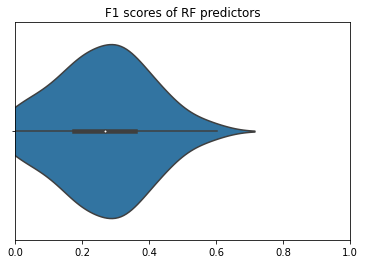

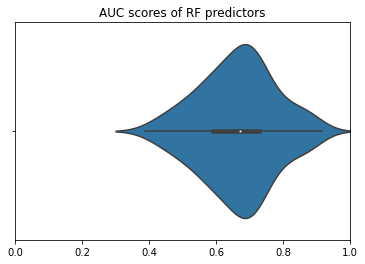

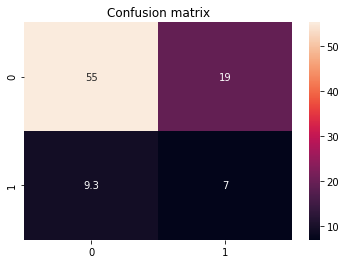

In [47]:
sns.violinplot(f1_scores)
plt.title("F1 scores of RF predictors")
plt.xlim([0, 1]);
plt.show()

sns.violinplot(roc_auc)
plt.title("AUC scores of RF predictors")
plt.xlim([0, 1]);
plt.show()

sns.heatmap(matrix, annot=True);
plt.title("Confusion matrix");
plt.show()

## Check significance of the results

In [52]:
def check_significance(model, get_metric, n_iters=100, column="icu"):
    shuffled = []
    proper = []
    for i in tqdm.trange(n_iters):
        try:
            X_train, y_train, X_test, y_test = get_random_split(column=column)
            res = get_metric(X_train, y_train, X_test, y_test, model)
            proper.append(res)

            np.random.shuffle(y_train)
            res = get_metric(X_train, y_train, X_test, y_test, model)
            shuffled.append(res)  
        except ValueError:
            pass
        
    significance = ttest_ind(proper, shuffled)
    if significance[1]<0.05:
        print(f"{np.mean(proper):.3f} mean (+{np.mean(proper)-np.mean(shuffled):.3f}), significant")
    else:
        print("Unsignificant")
    return proper, shuffled, significance[1]

In [53]:
# print("F1:")
# proper_acc, shuffled_acc, acc_pval = check_significance(lambda: ThresholdOptimPredictor(), get_metric=test_rf_accuracy)
pivoted.columns[-20:]

Index(['fname', 'run_y', 'ALT', 'AST', 'Białko ostrej fazy - CRP', 'D-dimer',
       'Ferrytyna', 'Interleukina 6', 'LDH (L)', 'height', 'weight', 'bmi',
       'obesity_calculated', 'sex', 'age', 'admission_date', 'final_date',
       'death', 'covid_test_date', 'icu'],
      dtype='object')

## Draw conclusions

In [55]:
column = "icu"
proper_res, shuffled_res, pval_res = check_significance(get_rf(n_estimators=200, max_features=None, criterion='gini', max_depth=2), get_metric=test_rf_auc, column=column)
samples = len(pivoted.loc[:, column].dropna().values)
p_val = round(pval_res, 4)
if p_val<0.05:
    p_val = "<0.05"
    
plt.figure(figsize=(8, 5))
sns.violinplot(data=pd.DataFrame({"Classifier": proper_res, "Baseline": shuffled_res}), cut=0)
plt.suptitle(f"Will the patient die?", fontweight='bold', fontsize='x-large')
plt.title(f"Permutation test p-val: {p_val}, {samples} samples")
plt.ylabel("AUC");
plt.xticks([])
plt.ylim([0, 1]);

  0%|                                                                                           | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

## Test on specific patients

In [57]:
train_patients, test_patients = train_test_split(pivoted['patient_id'].unique())
X_train, y_train, X_test, y_test = get_random_split("icu", train_patients, test_patients)
model = get_rf(n_estimators=200, max_features=None, criterion='gini', max_depth=2)()
model.fit(X_train, y_train);

In [65]:
patient

,run_x,sample_date,patient_id,samples,0.0,1.0,2.0,3.0,4.0,5.0,...,weight,bmi,obesity_calculated,sex,age,admission_date,final_date,death,covid_test_date,icu
191,Run4,2020-11-27,94,94_27112020_S35_aligned,0.0,0.0,0.0,1409.0,0.0,0.0,...,42.0,15.6,0,2.0,22.0,2020-11-13,2020-12-14,2.0,2020-11-12,0.0
192,Run4,2020-11-29,94,94_29112020_S36_aligned,0.0,0.0,0.0,2648.0,1.0,0.0,...,42.0,15.6,0,2.0,22.0,2020-11-13,2020-12-14,2.0,2020-11-12,0.0
193,Run4,2020-11-30,94,94_30112020_S37_aligned,0.0,0.0,0.0,1721.0,0.0,0.0,...,42.0,15.6,0,2.0,22.0,2020-11-13,2020-12-14,2.0,2020-11-12,0.0
194,Run4,2020-12-01,94,94_01122020_S38_aligned,0.0,0.0,0.0,347.0,0.0,0.0,...,42.0,15.6,0,2.0,22.0,2020-11-13,2020-12-14,2.0,2020-11-12,0.0
196,Run4,2020-12-05,94,94_05122020_S39_aligned,0.0,0.0,0.0,188.0,0.0,0.0,...,42.0,15.6,0,2.0,22.0,2020-11-13,2020-12-14,2.0,2020-11-12,0.0
198,Run4,2020-12-08,94,94_08122020_S40_aligned,0.0,0.0,60.0,142.0,0.0,0.0,...,42.0,15.6,0,2.0,22.0,2020-11-13,2020-12-14,2.0,2020-11-12,0.0


In [85]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

predictions = []
y_true = []
y_proba = []

for pid in test_patients:
    patient = pivoted.loc[pivoted["patient_id"]==pid]
    y_expected = patient['icu'].iloc[0]
    X_patient = patient.values[:, 4:-21]
    y_pred = model.predict_proba(X_patient)[:, 1]
    res = (y_pred>0.3).astype(int)

    y_proba.append(res.mean())
    predictions.append(res.min())
    y_true.append(y_expected)
    print(y_expected, res)
    
print(f"Accuracy: {accuracy_score(y_true, predictions)*100:.0f}%")
print(f"Precision: {precision_score(y_true, predictions)*100:.0f}%")
print(f"Recall: {recall_score(y_true, predictions)*100:.0f}%")
print(f"ROC: {roc_auc_score(y_true, y_proba)}")

0.0 [1 0 1 0 0]
0.0 [1 0]
0.0 [1 1 1 1]
0.0 [1 1 1 1 1]
0.0 [0 0 0 1]
0.0 [1 1 1 1]
0.0 [0 0 0 1 0]
1.0 [1 1]
0.0 [1 1 1 1 1 1]
0.0 [0 0 1 0 0 0]
0.0 [1 1 1 1 1]
0.0 [1 1 1 1 1]
1.0 [1 1 1 1]
1.0 [1 1 1 1 1 1]
0.0 [1 1]
0.0 [0 0 0 1 0 0]
0.0 [1 1 1 0 1 1]
0.0 [1 1 1 1 1 1]
0.0 [0 1]
0.0 [1 1 1 1]
0.0 [1 1 1 1 0 1]
Accuracy: 57%
Precision: 25%
Recall: 100%
ROC: 0.75


In [78]:
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

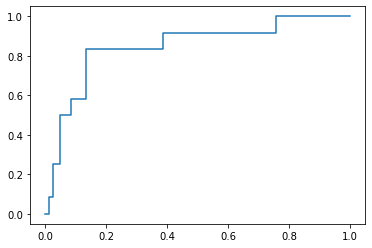

In [84]:
plt.plot(fpr, tpr)

In [273]:
model.predict(X_patient)

array([1., 0., 1., 1., 0.])